Một mô hình khác chúng ta có thể xây dựng, đó là mô hình GLM, dựa trên thống kê Bayes. Để xây dựng mô hình này, chúng ta sử dụng gói lệnh bambi trên python.

Thông qua các mô hình trước đó, ta thấy rằng hai cột có liên quan lớn nhất đến thời gian sử dụng email là:

- educ_center: Là cột biểu thị số năm học tập của cá nhân đó.
- wrkstat_Working_fulltime: Biểu thị việc cá nhân này có đang làm việc toàn thời gian hay không.

Từ đó, chúng ta xây dựng theo công thức sau: email_time_center ~ educ_center + wrkstat_Working_fulltime

Vì phân bố của biến đầu ra có dạng phân bố gamma, vì vậy chúng ta chọn family là "gamma" và hàm link function là hàm "log"

Sau khi xây dựng mô hình, chúng ta thực hiện các công việc sau:
- In ra giá trị của các tham số trong mô hình
- Xây dựng phân bố hậu nghiệm của biến đầu ra và kiểm tra phân bố này với dữ liệu thu được.
- Thực hiện việc dự đoán trên tập test và tính các chỉ số MSE, RMSE và $R^2$


       Formula: email_time_center ~ educ_center + wrkstat_Working_fulltime
        Family: gamma
          Link: mu = log
  Observations: 1319
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 11.5675)
            educ_center ~ Normal(mu: 0.0, sigma: 16.4563)
            wrkstat_Working_fulltime ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [email_time_center_alpha, Intercept, educ_center, wrkstat_Working_fulltime]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   
Intercept                -4.371  0.169  -4.688   -4.054      0.003    0.002  \
educ_center               1.730  0.254   1.273    2.217      0.005    0.003   
wrkstat_Working_fulltime  0.799  0.074   0.659    0.933      0.001    0.001   
email_time_center_alpha   0.580  0.018   0.544    0.614      0.000    0.000   

                          ess_bulk  ess_tail  r_hat  
Intercept                   3423.0    1581.0    1.0  
educ_center                 3165.0    1578.0    1.0  
wrkstat_Working_fulltime    3034.0    1654.0    1.0  
email_time_center_alpha     3895.0    1260.0    1.0  
Test MSE: 0.013266909383003714
Test RMSE: 0.11518207057959895
Test R^2: 0.07723117481734665


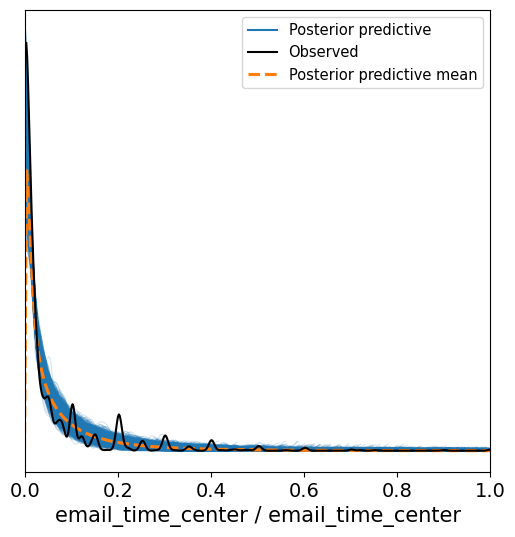

In [2]:
import re
import bambi as bmb
from matplotlib import pyplot as plt
import pandas as pd
import arviz as az
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def final_model(X_train, y_train, X_test, y_test, features, seed: int):
    X_train["email_time_center"] = pd.Series(y_train)
    X_test["email_time_center"] = pd.Series(y_test)
    model = bmb.Model(
        """email_time_center ~ educ_center + wrkstat_Working_fulltime""",
        X_train, dropna=True, family="gamma", link="log")
    print(model)

    _, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6))
    ax.set_xlim(xmin=0, xmax=1)
    ax.set_ylim(ymin=0, ymax=1)
    
    results = model.fit(draws=1000, chains=2)
    print(az.summary(results))

    # Diagnostics
    model.predict(results, data=X_test, kind="pps")
    az.plot_ppc(results, ax=ax)
    
    # predict
    model.predict(results, data=X_test, kind="mean")
    y_predict = np.array(results.posterior.email_time_center_mean[0, 999, :])
    
    mse = mean_squared_error(y_test, y_predict)
    rmse = mean_squared_error(y_test, y_predict, squared=False)
    r_square = r2_score(y_test, y_predict)
    print(f"Test MSE: {mse}")
    print(f"Test RMSE: {rmse}")
    print(f"Test R^2: {r_square}")

feature_choice = [
    ["wrkstat_Working_fulltime", "educ_center"]
]
X = pd.read_csv("data/preprocessing/X.csv")
y = pd.read_csv("data/preprocessing/y.csv")["email_time_center"].apply(lambda x: x+0.001)
f = lambda x: re.sub(' ','_', x, flags = re.IGNORECASE)
X.rename(columns = f, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for index, choice in enumerate(feature_choice):
    final_model(X_train, y_train, X_test, y_test, choice, index)

Các kết quả thu được từ đoạn code trên cho thấy:
- Phân bố hậu nghiệm của các tham số có trong mô hình trên đã hội tụ
- Phân bố hậu nghiệm của biến đầu ra phù hợp với dữ liệu nhận được ban đầu.